In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, dataset

In [ ]:
import os
BATCH_SIZE = 32
num_workers = os.cpu_count()

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(32, 32))
])

train_data = datasets.MNIST(root = "./data", train=True, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_data, batch_size= BATCH_SIZE, shuffle=True, num_workers=num_workers)

test_data = datasets.MNIST(root = "./data", train=False, transform=transform, download=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]


In [ ]:
class_names = train_data.classes

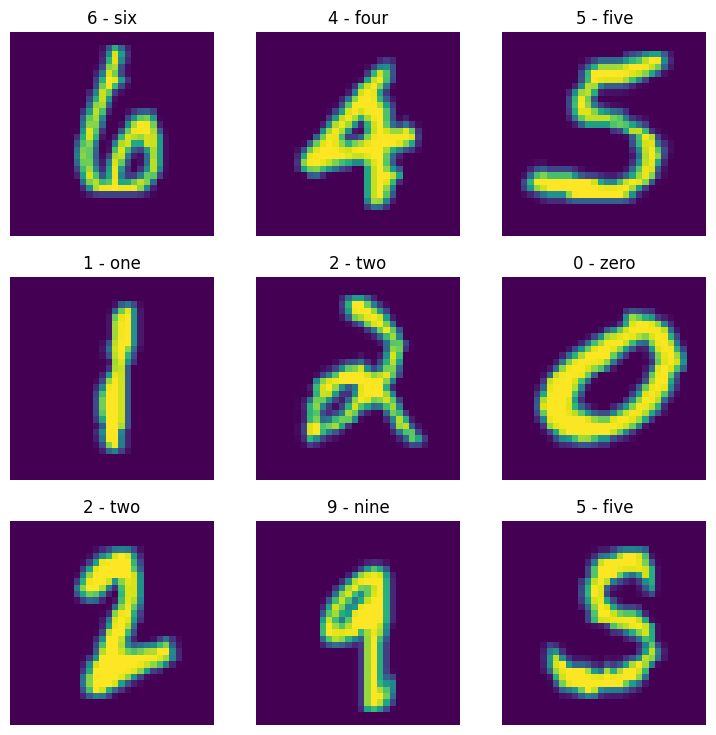

In [ ]:
import matplotlib.pyplot as plt
import random
fig = plt.figure(figsize=(9, 9))
row, col = 3, 3
for i in range(1, row*col+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 1, 32, 32])

In [ ]:
class LeNet(nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.conv_block = nn.Sequential(
                 nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0),
                 nn.Tanh(),
                 nn.AvgPool2d(kernel_size=2),
                 nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
                 nn.Tanh(),
                 nn.AvgPool2d(kernel_size=2),
                 nn.Conv2d(in_channels= 16, out_channels=120, kernel_size=5, stride= 1, padding=0),
                 nn.Tanh()
    )

    self.classifier = nn.Sequential(
                      nn.Linear(in_features=120, out_features=84),
                      nn.Tanh(),
                      nn.Linear(in_features=84, out_features=out_channels)
    )


  def forward(self, x):
    x = self.conv_block(x)
    x = torch.flatten(x, 1)  #[batch_size, channels, height, width] -> [batch_size, channels × height × width]
    x = self.classifier(x)
    return x

In [ ]:
model = LeNet(in_channels= 1, out_channels=len(class_names))
model

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
model.to(device)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----")

  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim =1).argmax(dim =1)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += (y_pred == y).sum().item()/len(y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)


  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      test_preds = torch.softmax(test_logits, dim= 1).argmax(dim = 1)

      test_loss += loss_fn(test_logits, y)
      test_acc += (test_preds==y).sum().item()/len(test_preds)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.64196 | Test loss: 0.35632, Test acc: 0.90%

Epoch: 1
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.31911 | Test loss: 0.25523, Test acc: 0.92%

Epoch: 2
----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.23742 | Test loss: 0.19161, Test acc: 0.94%



(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

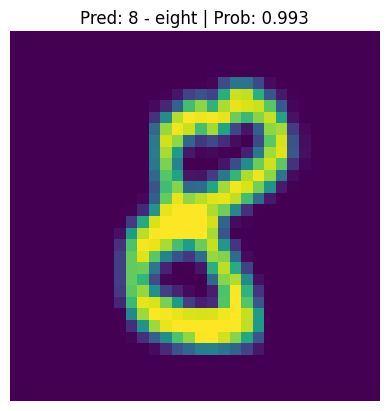

In [ ]:
import matplotlib.pyplot as plt

random_idx = torch.randint(0, len(test_data), size= [1]).item()
img, label = test_data[random_idx]

model.eval()
with torch.inference_mode():
  transformed_img = img.unsqueeze(0) # Add a batch dimension
  target_img_pred = model(transformed_img.to(device))
  target_img_pred_probs = torch.softmax(target_img_pred, dim = 1)
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim= 1)

plt.figure()
plt.imshow(img.permute(1, 2, 0))
plt.title(
      f"Pred: {class_names[target_img_pred_label]} | Prob: {target_img_pred_probs.max():.3f}"
    )
plt.axis(False)